In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb


In [3]:
"""
Connect the test and training data from csv files
"""
filepath = "/Users/sampark/Documents/Work/Kaggle/housePrices/"
filename_train = "train.csv"
filename_test = "test.csv"

train = pd.read_csv(filepath + filename_train)
test = pd.read_csv(filepath + filename_test)

In [6]:
"""
create original copies of the data and take a look at the shape of the data
"""
train_og = train.copy()
test_og = test.copy()

train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
train.shape

(1460, 81)

In [10]:
test.shape

(1459, 80)

In [11]:
"""
Combine training and test sets in order to process data before EDA and modeling
"""
data = pd.concat([train, test], keys=('x', 'y'))
data = data.drop(["Id"], axis = 1)

In [12]:
"""
Check for null values and remove columns with over 85% null values
"""
null_data = data.isnull().sum().sort_values(ascending=False)

null_percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([null_data, null_percentage], axis= 1, keys= ["Total", "Percentage"])

missing_data.head(20)

,Total,Percentage
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471


In [13]:
data = data.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "LotFrontage"],
                 axis = 1)

In [15]:
"""
Separate numerical and categorical variables and fill in null values with mean
and mode
"""
num_data = data._get_numeric_data().columns.tolist()

cat_data = set(data.columns) - set(num_data)

for col in num_data:
    data[col].fillna(data[col].mean(), inplace=True)
    
for col in cat_data:
    data[col].fillna(data[col].mode()[0], inplace=True)
    
data[num_data].isnull().sum()
data[cat_data].isnull().sum()

for i in cat_data:
    print(data[i].value_counts())

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64
PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64
Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64
TA    2688
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64
NAmes      443
CollgCr    267
OldTown    239

In [16]:
"""
Drop categorical columns with more than 80% of observations belonging to a single class
"""
data = data.drop(["LandSlope", "Condition2", "LandContour", "Street", "ExterCond",
                  "Condition1", "Functional", "Electrical", "CentralAir",
                  "Heating", "GarageQual", "RoofMatl", "BsmtCond", "PavedDrive",
                  "Utilities", "GarageCond", "BsmtFinType2"], axis= 1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

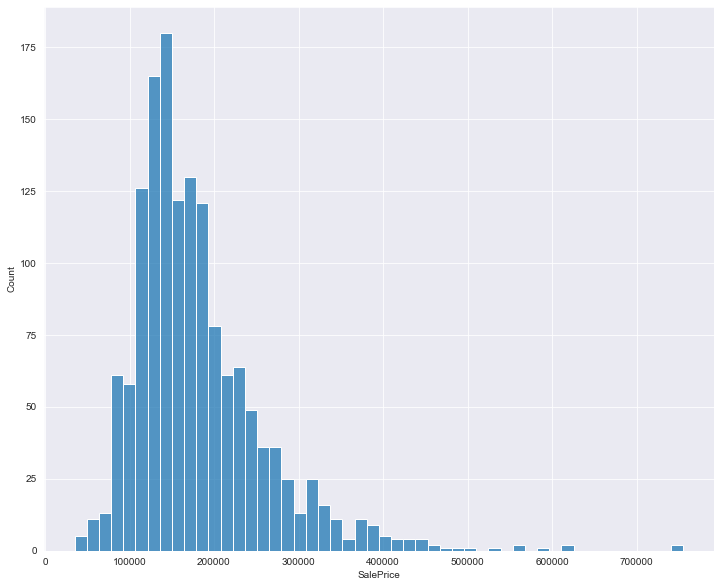

In [17]:
"""
EDA
"""
"""
Take a look at the distribution of SalePrice to check for normality. Since we can
see that there is skewness we can perform a log transformation to correct
"""
plt.figure(figsize=(12,10))

sns.set_style("darkgrid")
sns.histplot(data=train, x="SalePrice", bins=50, cbar=True)

In [18]:
train['SalePrice'] = np.log1p(train['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

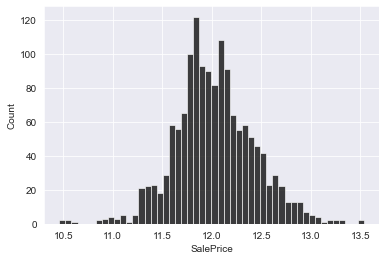

In [19]:
sns.set_style("darkgrid")
sns.histplot(data=train, x="SalePrice", bins=50, cbar=True, color='black')

In [20]:
data['SalePrice'] = np.log1p(data['SalePrice'])

In [21]:
"""
Rank variables based on correlation with SalePrice and drop variables with correlation
below .1
"""
corr = train.corr()
corr_rank = corr["SalePrice"].sort_values(ascending = False)
corr_rank

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

In [22]:
data = data.drop(["PoolArea", "MoSold", "3SsnPorch", "BsmtFinSF2", "BsmtHalfBath",
                  "MiscVal", "LowQualFinSF", "YrSold", "OverallCond", "MSSubClass"],
                 axis = 1)

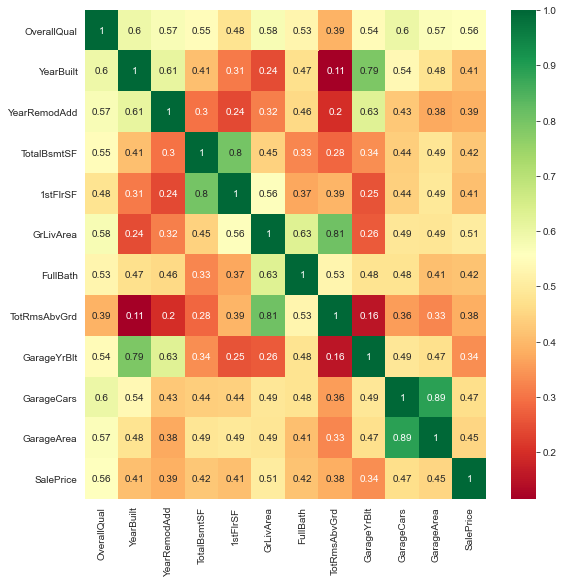

In [23]:
"""
Create correlation heatmap of variables with absolute correlation above 0.5
"""
top_features = corr.index[abs(corr["SalePrice"]>0.5)]
plt.figure(figsize = (9,9))
heat_map = sns.heatmap(data[top_features].corr(), annot=True, cmap="RdYlGn")

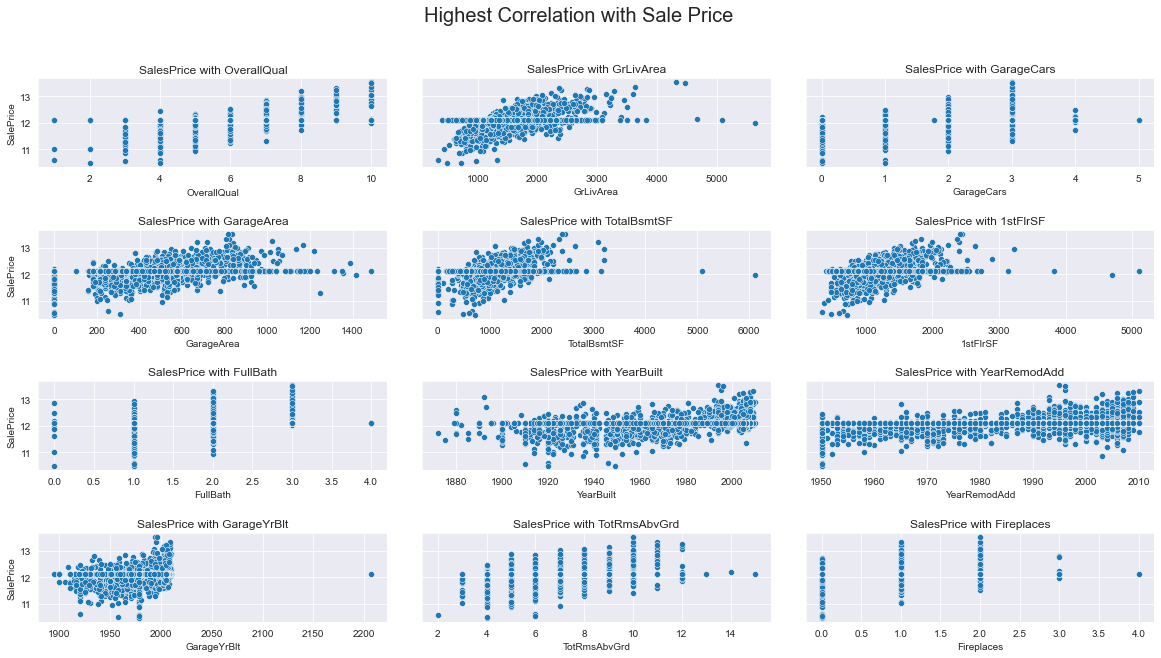

In [24]:
"""
Create scatterplots of 12 variables with the highest correlation to SalePrice
"""
corr_rank = corr_rank.drop(["SalePrice"])
sorted_corr = corr_rank.index.tolist()
fig, axes = plt.subplots(4, 3, figsize=(20,10), sharey= True)
fig.suptitle("Highest Correlation with Sale Price", fontsize= 20)
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
for i,col in zip(range(12), sorted_corr):
    sns.scatterplot(y=data['SalePrice'], x=data[col],ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('SalesPrice with '+col)

In [25]:
"""
Remove outliers of numeric variables by setting limits based on interquartile range
"""
n_features = data.select_dtypes(exclude = ["object"]).columns
n_features

Index(['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'SalePrice'],
      dtype='object')

In [26]:
data_outliers = data[["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF",
                "1stFlrSF", "2ndFlrSF", "GrLivArea", "GarageArea", "WoodDeckSF",
                "OpenPorchSF"]]

In [27]:
def mod_outliers(data):
    df1 = data.copy()
    data = data[["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF",
                "1stFlrSF", "2ndFlrSF", "GrLivArea", "GarageArea", "WoodDeckSF",
                "OpenPorchSF"]]
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for col in data.columns:
        for i in range(0, len(data[col])):
            if data[col][i] < lower_bound[col]:
                data[col][i] = lower_bound[col]
                
            if data[col][i] > upper_bound[col]:
                data[col][i] = upper_bound[col]
                
    for col in data.columns:
        df1[col] = data[col]
        
    return(df1)

data = mod_outliers(data)
data_outliers = mod_outliers(data_outliers)

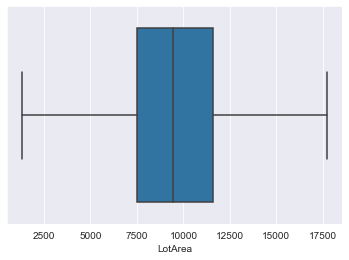

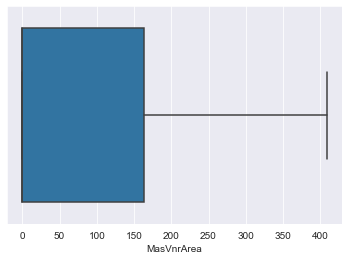

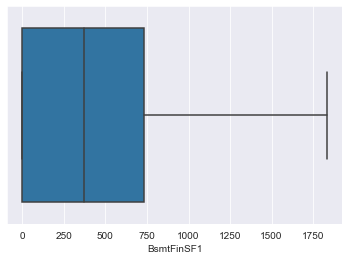

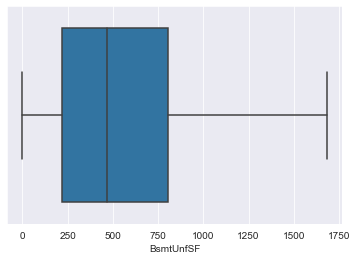

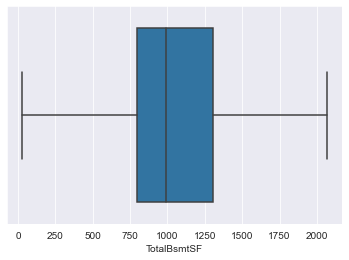

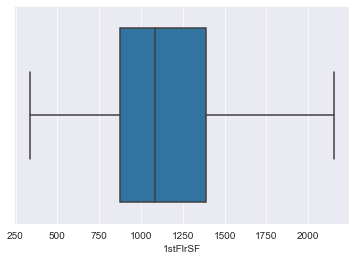

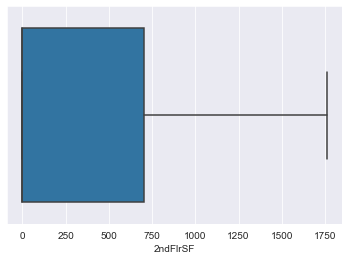

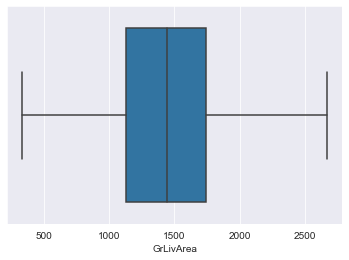

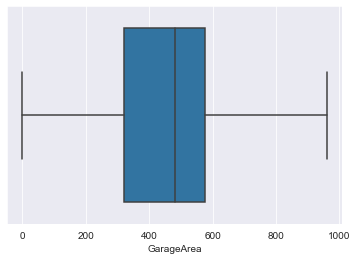

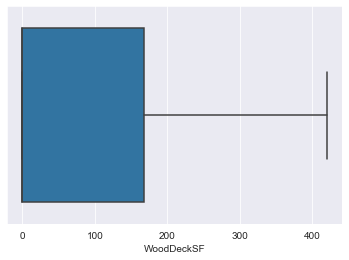

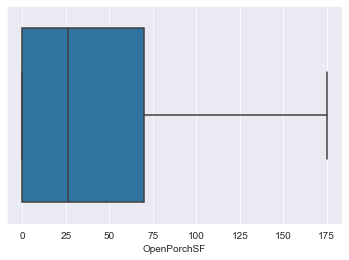

In [29]:
for i in data_outliers:
    sns.boxplot(x=data_outliers[i])
    plt.show()

In [30]:
"""
Convert categorical varialbes into dummy variables
"""
data = pd.get_dummies(data)

In [31]:
"""
Extract training and test sets after processing
"""
train = data.loc["x"]
test = data.loc["y"]
test = test.drop(["SalePrice"], axis = 1)

y = train["SalePrice"]
train_x = train.drop(["SalePrice"], axis = 1)
test_x = test

In [32]:
"""
Run machine learning algorithms and save final prediction for Kaggle submission
"""
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_x, y, scoring = "neg_mean_squared_error",
                                    cv = 5))
    return(rmse)

lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0001]).fit(train_x, y)
rmse_cv(lasso).mean()

ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 5, 10, 15, 30, 50, 75]).fit(train_x, y)
rmse_cv(ridge).mean()

model_xgb = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
model_xgb.fit(train_x, y)

lasso_preds = np.expm1(lasso.predict(test_x))
xgb_preds = np.expm1(model_xgb.predict(test_x))

preds = 0.7*lasso_preds + 0.3*xgb_preds

submission = pd.DataFrame({"id": test_og.Id, "SalePrice": preds})
submission.to_csv(filepath + "submission.csv", index = False)